# Matplotlib - Plotting Datasets in Python

In [2]:
# This line configures matplotlib to show figures embedded in the notebook, 
# instead of opening a new window for each figure.
%matplotlib inline
import numpy as np

In [3]:
# OPTIONAL: Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

## Introduction

Matplotlib is an excellent 2D and 3D graphics library for generating scientific figures. Some of the many advantages of this library include:

* Easy to get started
* Support for formatted labels and texts
* Great control of every element in a figure, including figure size and DPI. 
* High-quality output in many formats, including PNG, PDF, SVG, EPS, and PGF.

Matplotlib is designed to be similar to (and as usable as) [MATLAB](https://www.mathworks.com/products/matlab.html), a well-known (but not freely available) software for scientific and technical computing. For this reason, matplotlib was originally named to sound similar to MATLAB. Since then, its development has gone beyond MATLAB and is now significantly more powerful and flexible. In additition, matplotlib has the ability to use Python (unlike MATLAB), and has the added advantage of being free and open-source.

One of the key features of matplotlib that I would like to emphasize, and that I think makes matplotlib highly suitable for generating figures for scientific publications is that all aspects of the figure can be controlled *programmatically*. This is important for reproducibility and convenient when one needs to regenerate the figure with updated data or change its appearance. 

More information at the Matplotlib web page: http://matplotlib.org/

There are three ways to use matplotlib:

1. The full matplotlib API: This is the most powerful way. However, it has a sharp learning curve, especially for people who are inexperienced with object-oriented programming.
2. The `matplotlib.pyplot` submodule: This is a sub-module of matplotlib that is easier to use than the full module, but is more functionally limited. The design has some similarities with MATLAB.
3. The `pylab` module: This comes bundled with matplotlib, and is the easiest  to use. It is designed to be identical to MATLAB. However, it is not generally recommended due to its highly limited functionality.

We shall elect to use the most optimum way, the second. To get started using Matplotlib in a Python program, import the `matplotlib.pyplot` module under the name `plt` (the tidy way):

In [4]:
import matplotlib.pyplot as plt

# OPTIONAL: Set default figure size and font size
# For details on what this is, goto the last section of this notebook
plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams['font.size'] = 30

## The matplotlib.pyplot submodule: A Trivial Example

If we want to do a simply $xy$ plot of data, where the $x-$axis and $y-$axis data are present as two separate python lists or `NumPy` arrays, all you have to do is take the `plt` name imported above, use the `plt.plot()` function with the $x$ and $y$ arrays as arguments, then tell `plt` to display the result with the function `plt.show()`.

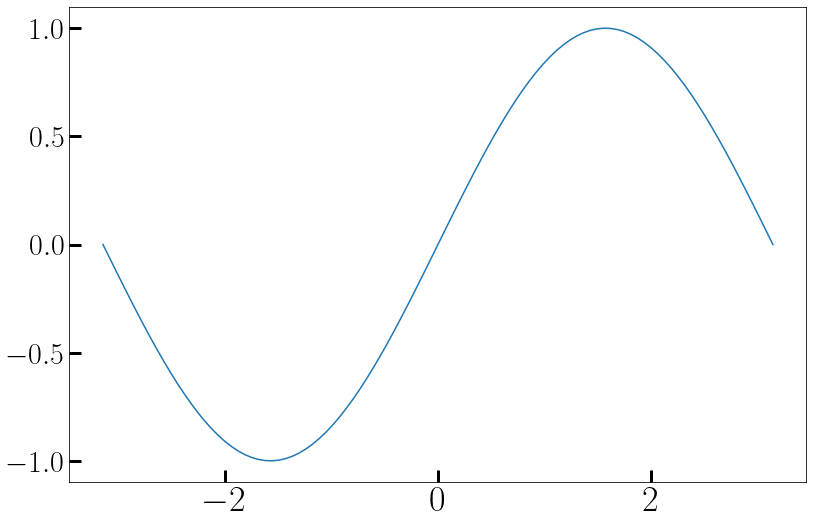

In [30]:
# Prepare the data
x = np.linspace(-np.pi, np.pi, 100)
y = np.sin(x)

plt.plot(x,y)
plt.show()

Note that, once `plt.show()` is executed successfully, the existing plt data is deleted inside `plt`.

You can add as many plots to this as you want. You can also create plot titles, $x$ and $y$ labels using the `plt.xlabels()` and `plt.ylabels()` functions.

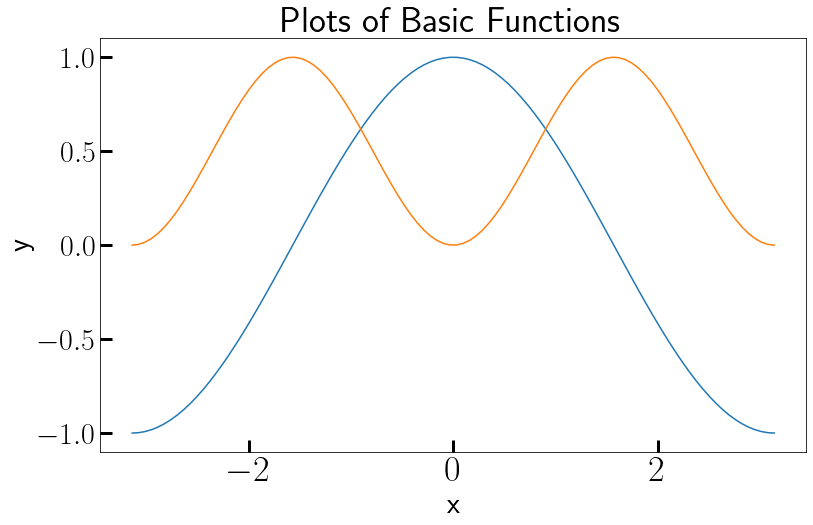

In [40]:
# Prepare the data
x = np.linspace(-np.pi, np.pi, 100)
plt.plot(x, np.cos(x))
plt.plot(x, np.sin(x)**2)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Plots of Basic Functions')
plt.show()

Note that the plot data from `np.sin(x)` put into `plt` in the previous code cell is gone.

If you just want to plot the points without drawing any lines connecting them, you can use the `plt.scatter()` function

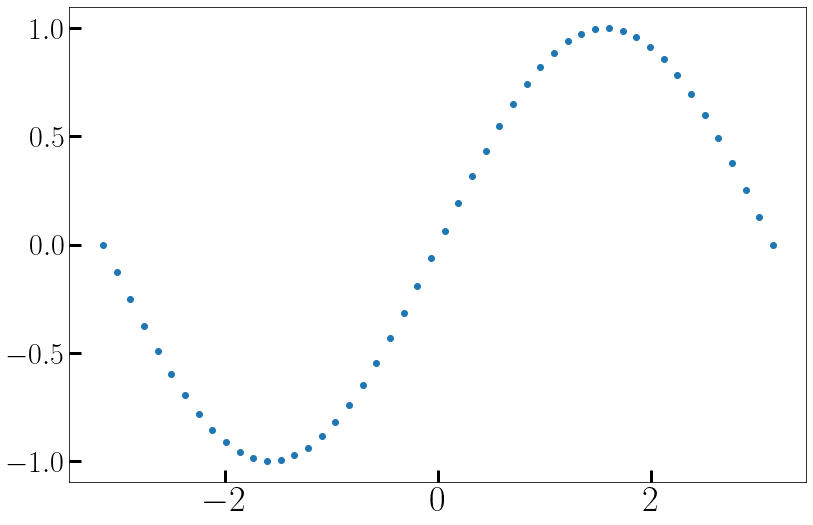

In [66]:
x = np.linspace(-np.pi, np.pi, 50)
y = np.sin(x)
plt.scatter(x,y)
plt.show()

### Plot External Data from File

Suppose that you have data output from another program or experiment. If the data is in a standard format like `csv` (comma-separated values), then importing it into a python session is very easy. Note that spreadsheet applications like Microsoft Excel **almost always** have options to export data in spreadsheets to `csv` files.

In `NumPy`, there is a function called `genfromtxt()` that can be used to load data from a txt (file), especially if it is in `csv` format. Using the function is easy. If `NumPy` is imported in the standard way, and the file is in the same folder as the program or notebook, then the code

```python
import numpy as np
a = np.genfromtxt('file_name.csv', delimiter=',')
```

will load all the data into a numpy array named 'a' of appropriate size and shape. The keyword `delimiter=','` specifies that the data is separated by comma. 

If the first row are data names instead of numbers, then the string values are treated as missing values, and `genfromtxt()` function will replace these missing values (string values) with a `nan` value. If you simply want to ignore them during import, then you 
can add an optional keyword `skip_headers=1` to `genfromtxt()`. This simply skips importing the first line of the file.

```python
import numpy as np
a = np.genfromtxt('file_name.csv', delimiter=',', skip_header=1)
```

### Exercise 01

There is sample data from an experiment involving percentage concentration of salt as a function of temperature. It is in a file named 

```bash
'data/salt_data.csv' 
```

The file is named 'salt_data.csv' in the sub-folder named 'data'. The data is also reproduced below:

| Temp (C) | wt% |
|----------|-----|
| -1       | 1.1 |
| -2       | 2.2 |
| -2.3     | 2.5 |
| -2.5     | 2.8 |
| -2.69    | 3   |
| -2.93    | 3.2 |
| -3.1     | 3.4 |

Use the `genfromtxt()` function in `NumPy` to import the data, skipping the column names as needed. Use `matplotlib` to plot the data (wt versus temperature) and include appropriate axis labels.

## The matplotlib object-oriented API: A Simple Example

If you have lots of complex scientific and technical data that you need to plot, you may need to go beyond the example above and do more complex things with the matplotlib API. The main idea with object-oriented programming is to have objects that one can apply functions and actions on, and no object or program states should be global (such as with MATLAB). The real advantage of this approach becomes apparent when more than one figure is created, or when a figure contains more than one subplot. 

To use the object-oriented API, we store a reference to the newly created figure instance in the `fig` variable, and from it we create a new axis instance `ax` using the `add_axes` method in the `Figure` class instance `fig`:

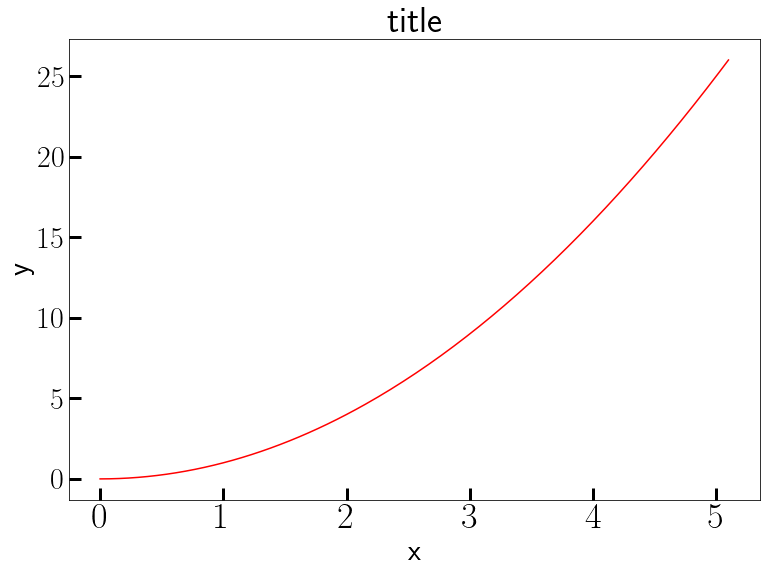

In [68]:
# Prepare the data
x = np.linspace(0.0, 5.1, 200)
y = x**2

# Prepare the figure
fig = plt.figure()

# Prepare the x and y axes
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # left, bottom, width, height (range 0 to 1)

#Plot the data in the axes
ax.plot(x, y, 'r')

#Set the axes titles and labels
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('title');

# Show the plot
plt.show()

## The matplotlib.pyplot Workflow

So, let us summarize the workflow for creating a single plot. Assuming that you have imported `matplotlib.pyplot` into a name, say `plt`, and prepared your data as `NumPy` arrays (or regular python lists or tuples), you must:

1. Create a *Figure Canvas* as an object inside `plt` using `plt.figure()` and assign it to a variable, say `fig`. 
2. For each $xy$ dataset, add a pair of $xy$ axes as an object inside the canvas using `fig.add_axes()` and assign it to a variable, say `ax`.
3. For each `ax`, prepare the plot of the data you want to put in `ax` using `ax.plot()`
4. Optionally, set the titles and labels for the $x$ and $y$ axes for each `ax` object.
5. Display the plot with `plt.show()`

## The matplotlib.pyplot API: Defaults and More Complex Examples
Although a little bit more code is involved, the advantage is that we now have full control of where the plot axes are placed, and we can easily add more than one axis to the figure. Suppose we want to add another data plot as an inset to the previous one.

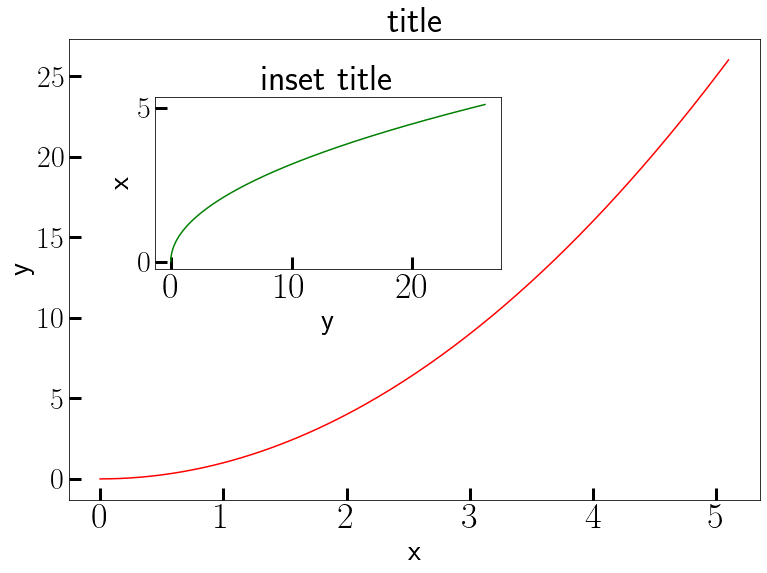

In [19]:
fig = plt.figure() # Note that this clears any previous canvasses in `plt`

ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes
ax2 = fig.add_axes([0.2, 0.5, 0.4, 0.3]) # inset axes

# main figure
ax1.plot(x, y, 'r')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('title')

# insert
ax2.plot(y, x, 'g')
ax2.set_xlabel('y')
ax2.set_ylabel('x')
ax2.set_title('inset title');
plt.show()

If we don't care about being explicit about where our plot axes are placed in the figure canvas, then we can use one of the many axis layout managers in matplotlib. My favorite is `subplots`, which can be used like this:

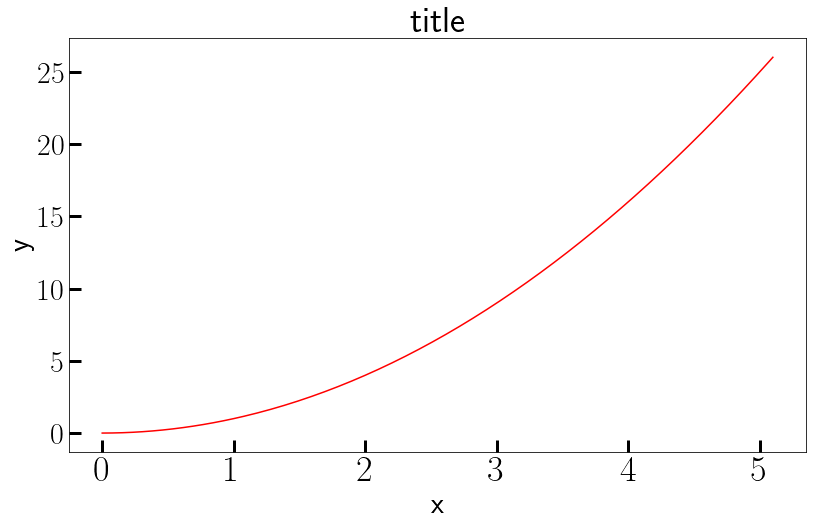

In [20]:
fig, ax = plt.subplots()

ax.plot(x, y, 'r')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('title');
plt.show()

If you want to create two subplots, the easiest way is to supply the layout as keyword arguments to `plt.subplots()`. This is easier than the above-mentioned method manipulating individual axes layouts.

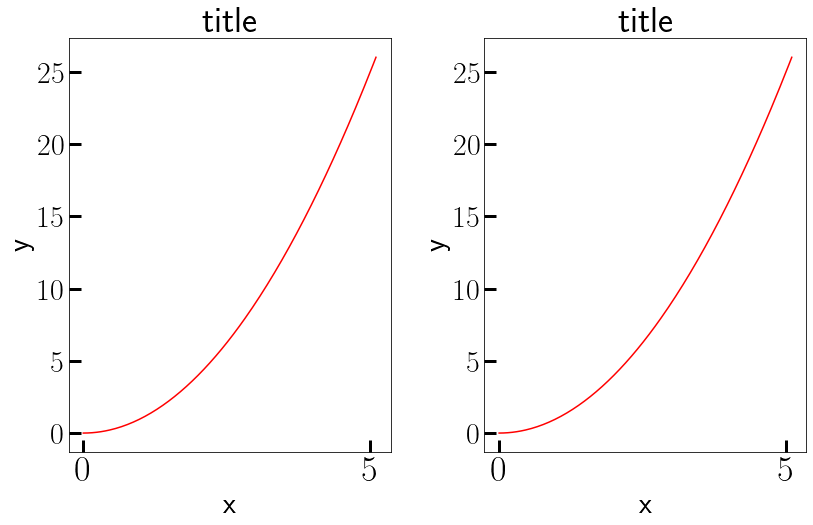

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2)

#axes is an array of two 'ax' objects
for ax in axes:
    ax.plot(x, y, 'r')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('title')
    
fig.tight_layout() # Just in case the axes overlap
plt.show()

### Exercise 02:
1. From the output of the above program, display the value of `axes` to check if it is an array or not.
   
2. The code cell below generates some data. Add code to it to create a figure object and put two axes on it, ax1 and ax2, located at [0,0,1,1] and [0.2,0.5,.2,.2] respectively. Then, in the main axes, plot 'z' versus 'x'. In the inset, plot 'y' vs 'x'. **Include all axes labels**.

In [ ]:
import numpy as np
x = np.arange(0,100)
y = x*2
z = x**2

### Legends, labels and titles

Now that we have covered the basics of how to create a figure canvas and add axes instances to the canvas, let's look at how decorate a figure with titles, axis labels, and legends.

**Figure titles**

A title can be added to each axis instance in a figure. To set the title, use the `set_title` method in the axes instance:

In [36]:
ax.set_title("title");

**Axis labels**

Similarly, with the methods `set_xlabel` and `set_ylabel`, we can set the labels of the X and Y axes:

In [37]:
ax.set_xlabel("x")
ax.set_ylabel("y");

**Legends**

Legends for curves in a figure can be added by using the `label="label text"` keyword argument when plots or other objects are added to the figure, and then using the `legend` method without arguments to add the legend to the figure:

In [38]:
ax.plot(x, x**2, label="curve1")
ax.plot(x, x**3, label="curve2")
ax.legend();

If curves are added or removed from the figure, the legend is automatically updated accordingly.

### Exercise 03:

Take the data from the previous exercise and plot them again, this time in just one plot (no insets). However, add labels explaining the meaning of each dataset, as well as plot titles, a legend, and proper axis labels.